In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Global\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Global\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Global\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load the dataset (replace the file paths with your dataset location)
train_data = pd.read_csv("new_train_data_s140.csv", encoding='ISO-8859-1')
test_data = pd.read_csv("new_test_data_s140.csv", encoding='ISO-8859-1')

In [4]:
# Rename columns for easier access
columns = ['Polarity', 'Id', 'Date', 'Query', 'User', 'Text']
train_data.columns = columns
test_data.columns = columns

In [5]:
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Drop irrelevant columns
combined_data = combined_data.drop(['Id', 'Date', 'Query', 'User'], axis=1)

In [6]:
# Check the shape of the combined dataset
print("Combined Data Shape:", combined_data.shape)

# Check for null values
print("Null values in Train Data:\n", train_data.isnull().sum())
print("Null values in Test Data:\n", test_data.isnull().sum())

Combined Data Shape: (1600494, 2)
Null values in Train Data:
 Polarity    0
Id          0
Date        0
Query       0
User        0
Text        0
dtype: int64
Null values in Test Data:
 Polarity    0
Id          0
Date        0
Query       0
User        0
Text        0
dtype: int64


In [7]:
# Clean text function
def clean_text(text):
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization (reduce words to their base form)
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    # Join the tokens back into a single string
    clean_text = ' '.join(lemmatized_text)
    return clean_text

In [8]:
# Apply text cleaning to both training and testing datasets
train_data['Clean_Text'] = train_data['Text'].apply(clean_text)
test_data['Clean_Text'] = test_data['Text'].apply(clean_text)

# Check the cleaned data
print(train_data[['Text', 'Clean_Text']].head())

                                                Text  \
0  @Kenichan I dived many times for the ball. Man...   
1    my whole body feels itchy and like its on fire    
2  @nationwideclass no, it's not behaving at all....   
3                      @Kwesidei not the whole crew    
4                                        Need a hug    

                                        Clean_Text  
0  dived many time ball managed save rest go bound  
1                  whole body feel itchy like fire  
2                         behaving im mad cant see  
3                                       whole crew  
4                                         need hug  


In [9]:
# Split the dataset for training
X = train_data['Clean_Text']  # Features (cleaned text)
y = train_data['Polarity']    # Target (sentiment polarity)

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Limit the number of features for simplicity

# Fit the vectorizer on training data and transform both train and validation sets
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Check the TF-IDF matrix
print("TF-IDF train matrix shape:", X_train_tfidf.shape)
print("TF-IDF validation matrix shape:", X_val_tfidf.shape)

TF-IDF train matrix shape: (1279998, 5000)
TF-IDF validation matrix shape: (320000, 5000)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred = model.predict(X_val_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

C:\Users\Global\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.774928125
Confusion Matrix:
 [[120249  39245]
 [ 32778 127728]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77    159494
           4       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.78      0.77      0.77    320000
weighted avg       0.78      0.77      0.77    320000



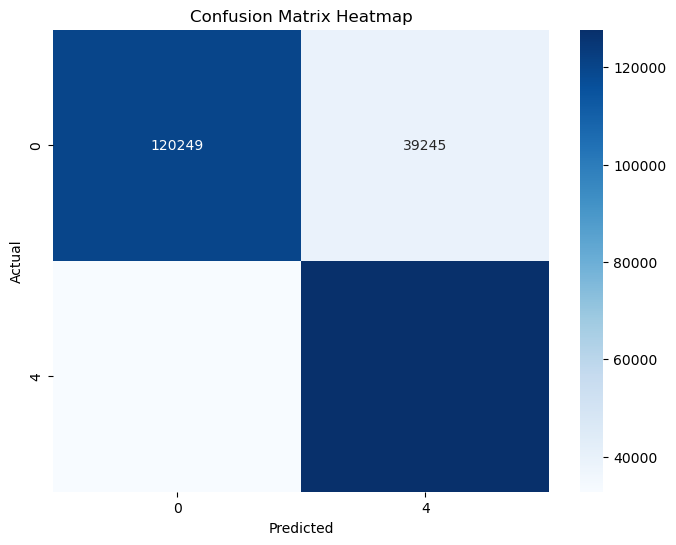

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap visualization
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

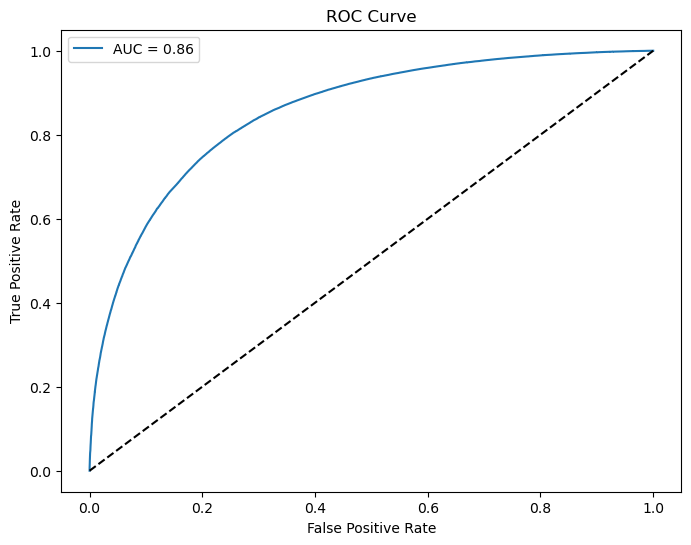

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities for the positive class
y_prob = model.predict_proba(X_val_tfidf)[:, 1]

# Compute ROC curve and AUC, setting pos_label to 4
fpr, tpr, thresholds = roc_curve(y_val, y_prob, pos_label=4)
auc_score = roc_auc_score(y_val, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


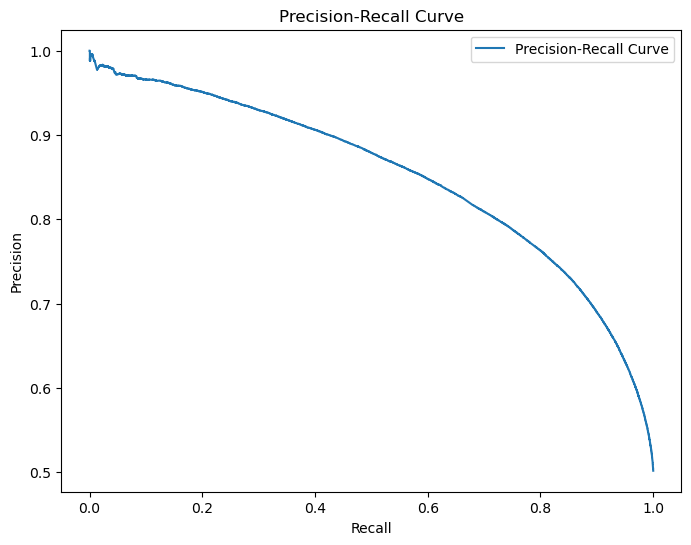

In [13]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve, specifying the positive class
precision, recall, thresholds = precision_recall_curve(y_val, y_prob, pos_label=4)

# Plot the Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

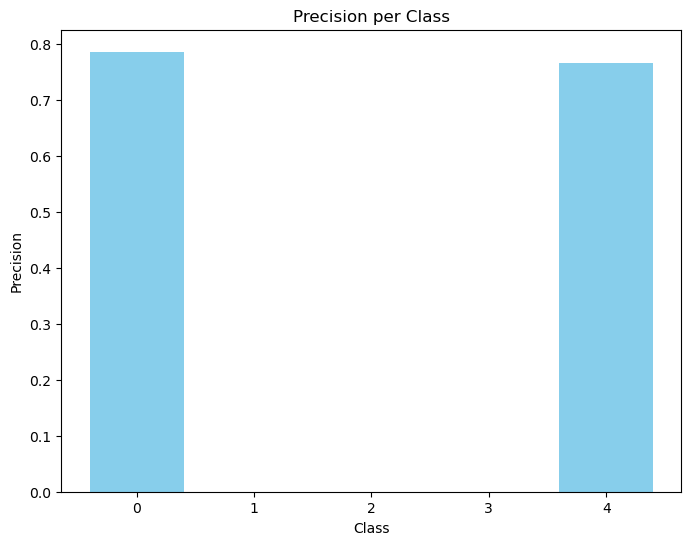

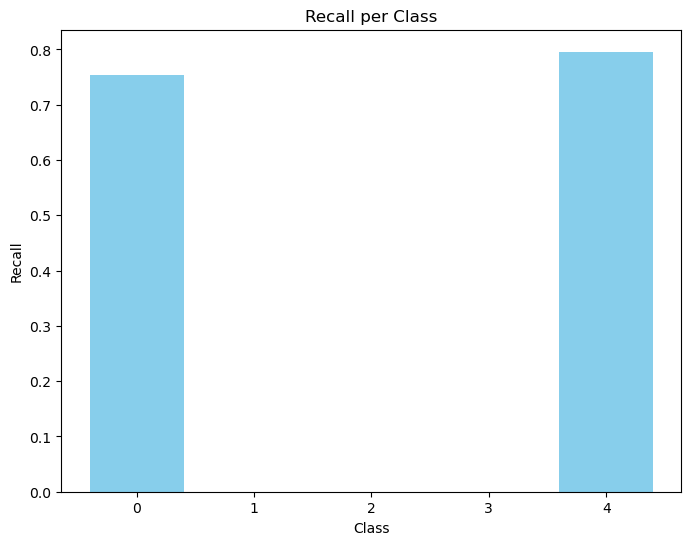

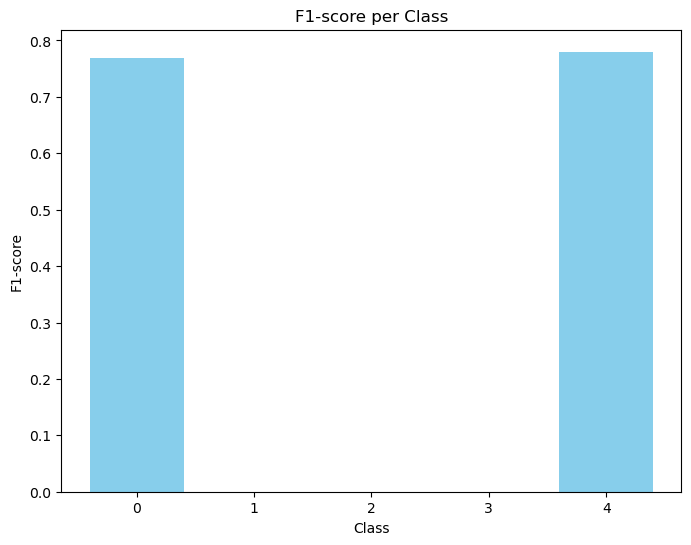

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get the classification report as a dictionary
report = classification_report(y_val, y_pred, output_dict=True)

# Extract precision, recall, and f1-score for each class
metrics = ['precision', 'recall', 'f1-score']
classes = model.classes_

# Plot the metrics for each class
for metric in metrics:
    values = [report[str(cls)][metric] for cls in classes]
    plt.figure(figsize=(8,6))
    plt.bar(classes, values, color='skyblue')
    plt.title(f'{metric.capitalize()} per Class')
    plt.xlabel('Class')
    plt.ylabel(metric.capitalize())
    plt.show()